# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, imaging_type_encoder=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:  # Use same flag as label encoder for consistency
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Get the fitted imaging type encoder
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Print encoding information
print(f"Tissue Types: {label_encoder.classes_}")

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
class AlexNetWithImagingType(nn.Module):
    """Wrapper class that adds imaging type embedding to AlexNet"""
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(AlexNetWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Replace the final classifier layer with identity to get features
        self.base_model.classifier[6] = nn.Identity()
        
        # Create embedding for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes image features + imaging type embedding
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features from base model
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_alexnet_model(num_classes=4, num_imaging_types=2, pretrained=True):
    """
    Create AlexNet model with imaging type support for multi-class classification
    
    Args:
        num_classes (int): Number of output classes
        num_imaging_types (int): Number of imaging types
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: AlexNet model with imaging type embedding
    """
    # Load pretrained AlexNet
    base_model = models.alexnet(weights='DEFAULT' if pretrained else None)
    
    # Get number of features before modifying the classifier
    num_features = base_model.classifier[6].in_features
    
    # Wrap model with imaging type support
    model = AlexNetWithImagingType(
        base_model,
        num_features=num_features,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types
    )
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train AlexNet

Training AlexNet with Imaging Type
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 211MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.55it/s, Loss=1.6647, Acc=0.3832]


Train Loss: 1.6647 Acc: 0.3832 Macro-F1: 0.3362


Val : 100%|██████████| 10/10 [00:01<00:00,  5.63it/s, Loss=1.4124, Acc=0.0724]


Val Loss: 1.4124 Acc: 0.0724 Macro-F1: 0.0337
✓ New best model saved with validation macro-F1: 0.0337

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.79it/s, Loss=1.3804, Acc=0.1965]


Train Loss: 1.3804 Acc: 0.1965 Macro-F1: 0.1906


Val : 100%|██████████| 10/10 [00:01<00:00,  9.47it/s, Loss=1.3456, Acc=0.2895]


Val Loss: 1.3456 Acc: 0.2895 Macro-F1: 0.1636
✓ New best model saved with validation macro-F1: 0.1636

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.89it/s, Loss=1.3806, Acc=0.2812]


Train Loss: 1.3806 Acc: 0.2812 Macro-F1: 0.2478


Val : 100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Loss=1.3610, Acc=0.2500]


Val Loss: 1.3610 Acc: 0.2500 Macro-F1: 0.1595

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.79it/s, Loss=1.3804, Acc=0.2681]


Train Loss: 1.3804 Acc: 0.2681 Macro-F1: 0.2521


Val : 100%|██████████| 10/10 [00:01<00:00,  9.19it/s, Loss=1.3610, Acc=0.3289]


Val Loss: 1.3610 Acc: 0.3289 Macro-F1: 0.1849
✓ New best model saved with validation macro-F1: 0.1849

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.65it/s, Loss=1.3808, Acc=0.2574]


Train Loss: 1.3808 Acc: 0.2574 Macro-F1: 0.2438


Val : 100%|██████████| 10/10 [00:01<00:00,  9.25it/s, Loss=1.3699, Acc=0.2500]


Val Loss: 1.3699 Acc: 0.2500 Macro-F1: 0.1595

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.41it/s, Loss=1.3776, Acc=0.2294]


Train Loss: 1.3776 Acc: 0.2294 Macro-F1: 0.2138


Val : 100%|██████████| 10/10 [00:01<00:00,  9.15it/s, Loss=1.3717, Acc=0.3289]


Val Loss: 1.3717 Acc: 0.3289 Macro-F1: 0.1849

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.74it/s, Loss=1.3859, Acc=0.2804]


Train Loss: 1.3859 Acc: 0.2804 Macro-F1: 0.2269


Val : 100%|██████████| 10/10 [00:01<00:00,  9.43it/s, Loss=1.3761, Acc=0.2895]


Val Loss: 1.3761 Acc: 0.2895 Macro-F1: 0.1768

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.73it/s, Loss=1.3299, Acc=0.3692]


Train Loss: 1.3299 Acc: 0.3692 Macro-F1: 0.2934


Val : 100%|██████████| 10/10 [00:01<00:00,  8.40it/s, Loss=1.1876, Acc=0.5164]


Val Loss: 1.1876 Acc: 0.5164 Macro-F1: 0.4611
✓ New best model saved with validation macro-F1: 0.4611

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.98it/s, Loss=1.1413, Acc=0.5312]


Train Loss: 1.1413 Acc: 0.5312 Macro-F1: 0.4743


Val : 100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Loss=0.8926, Acc=0.7039]


Val Loss: 0.8926 Acc: 0.7039 Macro-F1: 0.6302
✓ New best model saved with validation macro-F1: 0.6302

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.63it/s, Loss=1.0109, Acc=0.6332]


Train Loss: 1.0109 Acc: 0.6332 Macro-F1: 0.5701


Val : 100%|██████████| 10/10 [00:01<00:00,  9.04it/s, Loss=0.7971, Acc=0.6842]


Val Loss: 0.7971 Acc: 0.6842 Macro-F1: 0.5918

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.52it/s, Loss=0.9320, Acc=0.6571]


Train Loss: 0.9320 Acc: 0.6571 Macro-F1: 0.5926


Val : 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, Loss=0.6794, Acc=0.7763]


Val Loss: 0.6794 Acc: 0.7763 Macro-F1: 0.6917
✓ New best model saved with validation macro-F1: 0.6917

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.58it/s, Loss=0.8185, Acc=0.6916]


Train Loss: 0.8185 Acc: 0.6916 Macro-F1: 0.6340


Val : 100%|██████████| 10/10 [00:01<00:00,  8.86it/s, Loss=0.6013, Acc=0.7895]


Val Loss: 0.6013 Acc: 0.7895 Macro-F1: 0.7379
✓ New best model saved with validation macro-F1: 0.7379

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.80it/s, Loss=0.7858, Acc=0.7113]


Train Loss: 0.7858 Acc: 0.7113 Macro-F1: 0.6481


Val : 100%|██████████| 10/10 [00:01<00:00,  9.42it/s, Loss=0.6163, Acc=0.8158]


Val Loss: 0.6163 Acc: 0.8158 Macro-F1: 0.7705
✓ New best model saved with validation macro-F1: 0.7705

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.30it/s, Loss=0.7479, Acc=0.7360]


Train Loss: 0.7479 Acc: 0.7360 Macro-F1: 0.6792


Val : 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Loss=0.7299, Acc=0.7105]


Val Loss: 0.7299 Acc: 0.7105 Macro-F1: 0.6773

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.60it/s, Loss=0.7264, Acc=0.7171]


Train Loss: 0.7264 Acc: 0.7171 Macro-F1: 0.6729


Val : 100%|██████████| 10/10 [00:01<00:00,  9.51it/s, Loss=0.4838, Acc=0.8651]


Val Loss: 0.4838 Acc: 0.8651 Macro-F1: 0.8217
✓ New best model saved with validation macro-F1: 0.8217

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.52it/s, Loss=0.6596, Acc=0.7722]


Train Loss: 0.6596 Acc: 0.7722 Macro-F1: 0.7222


Val : 100%|██████████| 10/10 [00:01<00:00,  9.50it/s, Loss=0.4825, Acc=0.8618]


Val Loss: 0.4825 Acc: 0.8618 Macro-F1: 0.8191

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.65it/s, Loss=0.6179, Acc=0.7747]


Train Loss: 0.6179 Acc: 0.7747 Macro-F1: 0.7203


Val : 100%|██████████| 10/10 [00:01<00:00,  9.18it/s, Loss=0.4605, Acc=0.8717]


Val Loss: 0.4605 Acc: 0.8717 Macro-F1: 0.8328
✓ New best model saved with validation macro-F1: 0.8328

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.48it/s, Loss=0.6305, Acc=0.7829]


Train Loss: 0.6305 Acc: 0.7829 Macro-F1: 0.7334


Val : 100%|██████████| 10/10 [00:01<00:00,  9.61it/s, Loss=0.4649, Acc=0.8684]


Val Loss: 0.4649 Acc: 0.8684 Macro-F1: 0.8246

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.68it/s, Loss=0.5999, Acc=0.8183]


Train Loss: 0.5999 Acc: 0.8183 Macro-F1: 0.7691


Val : 100%|██████████| 10/10 [00:01<00:00,  9.29it/s, Loss=0.4545, Acc=0.8783]


Val Loss: 0.4545 Acc: 0.8783 Macro-F1: 0.8328
✓ New best model saved with validation macro-F1: 0.8328

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.45it/s, Loss=0.5979, Acc=0.8059]


Train Loss: 0.5979 Acc: 0.8059 Macro-F1: 0.7579


Val : 100%|██████████| 10/10 [00:01<00:00,  9.49it/s, Loss=0.4454, Acc=0.8980]


Val Loss: 0.4454 Acc: 0.8980 Macro-F1: 0.8646
✓ New best model saved with validation macro-F1: 0.8646

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.57it/s, Loss=0.6156, Acc=0.7706]


Train Loss: 0.6156 Acc: 0.7706 Macro-F1: 0.7252


Val : 100%|██████████| 10/10 [00:01<00:00,  9.65it/s, Loss=0.4368, Acc=0.8849]


Val Loss: 0.4368 Acc: 0.8849 Macro-F1: 0.8377

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.46it/s, Loss=0.5936, Acc=0.7969]


Train Loss: 0.5936 Acc: 0.7969 Macro-F1: 0.7507


Val : 100%|██████████| 10/10 [00:01<00:00,  9.41it/s, Loss=0.4345, Acc=0.8882]


Val Loss: 0.4345 Acc: 0.8882 Macro-F1: 0.8402

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.52it/s, Loss=0.5969, Acc=0.7854]


Train Loss: 0.5969 Acc: 0.7854 Macro-F1: 0.7318


Val : 100%|██████████| 10/10 [00:01<00:00,  9.28it/s, Loss=0.4335, Acc=0.8914]


Val Loss: 0.4335 Acc: 0.8914 Macro-F1: 0.8497

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.92it/s, Loss=0.5802, Acc=0.7878]


Train Loss: 0.5802 Acc: 0.7878 Macro-F1: 0.7377


Val : 100%|██████████| 10/10 [00:01<00:00,  8.79it/s, Loss=0.4321, Acc=0.8882]


Val Loss: 0.4321 Acc: 0.8882 Macro-F1: 0.8402

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.75it/s, Loss=0.5669, Acc=0.7911]


Train Loss: 0.5669 Acc: 0.7911 Macro-F1: 0.7426


Val : 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Loss=0.4302, Acc=0.8882]


Val Loss: 0.4302 Acc: 0.8882 Macro-F1: 0.8402
Early stopping triggered after 25 epochs
Training complete in 2m 6s
Best validation macro-F1: 0.8646


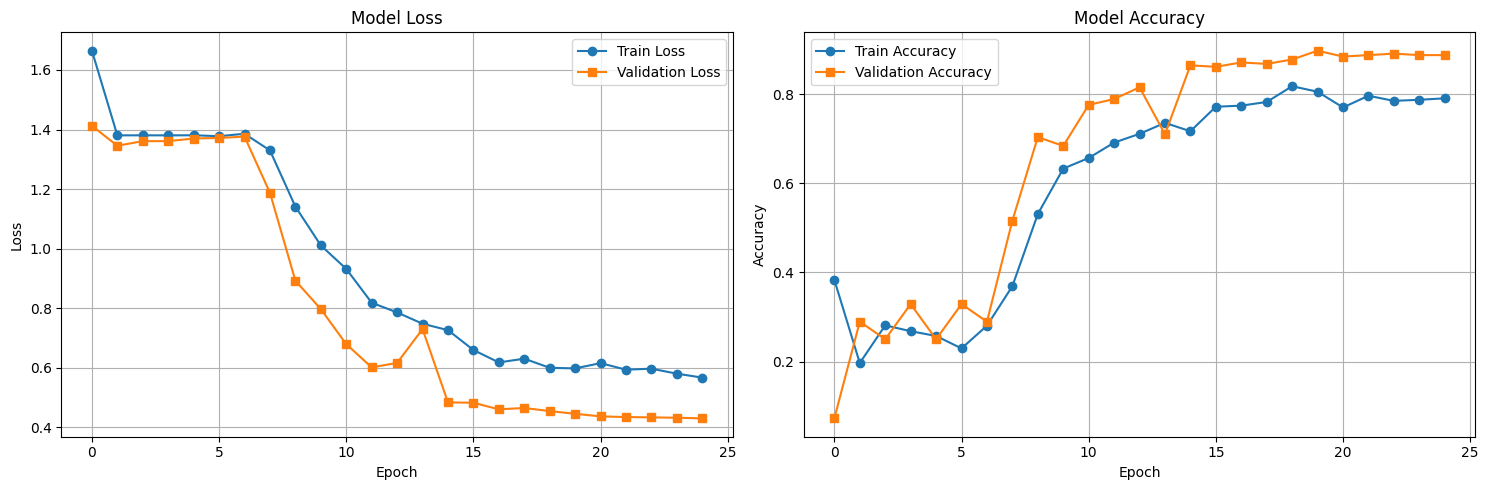

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Test Accuracy: 51.32%
Test Loss: 1.4971

Classification Report:
              precision    recall  f1-score   support

         HGC       0.62      0.51      0.56        74
         LGC       0.67      0.45      0.54        53
         NST       0.44      0.78      0.56        37
         NTL       0.23      0.24      0.24        25

    accuracy                           0.51       189
   macro avg       0.49      0.50      0.48       189
weighted avg       0.55      0.51      0.51       189


Confusion Matrix:
[[38  6 22  8]
 [20 24  0  9]
 [ 2  3 29  3]
 [ 1  3 15  6]]

ROC-AUC Scores:
Macro-average AUC: 0.7021
Micro-average AUC: 0.7056
HGC AUC: 0.6055
LGC AUC: 0.8272
NST AUC: 0.8428
NTL AUC: 0.5329


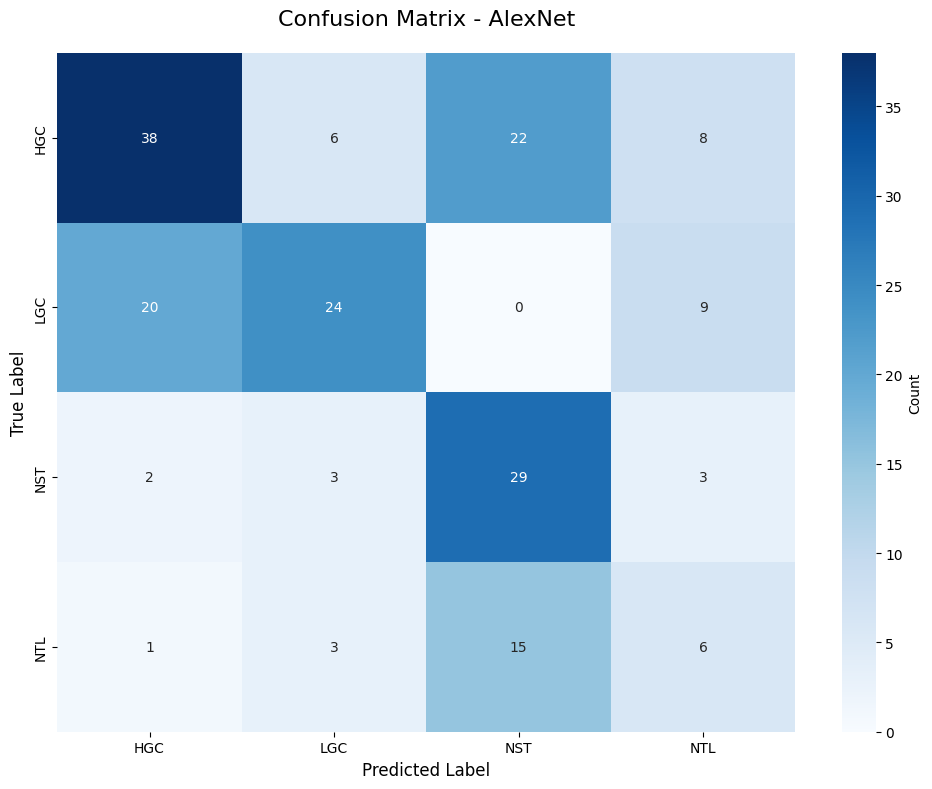

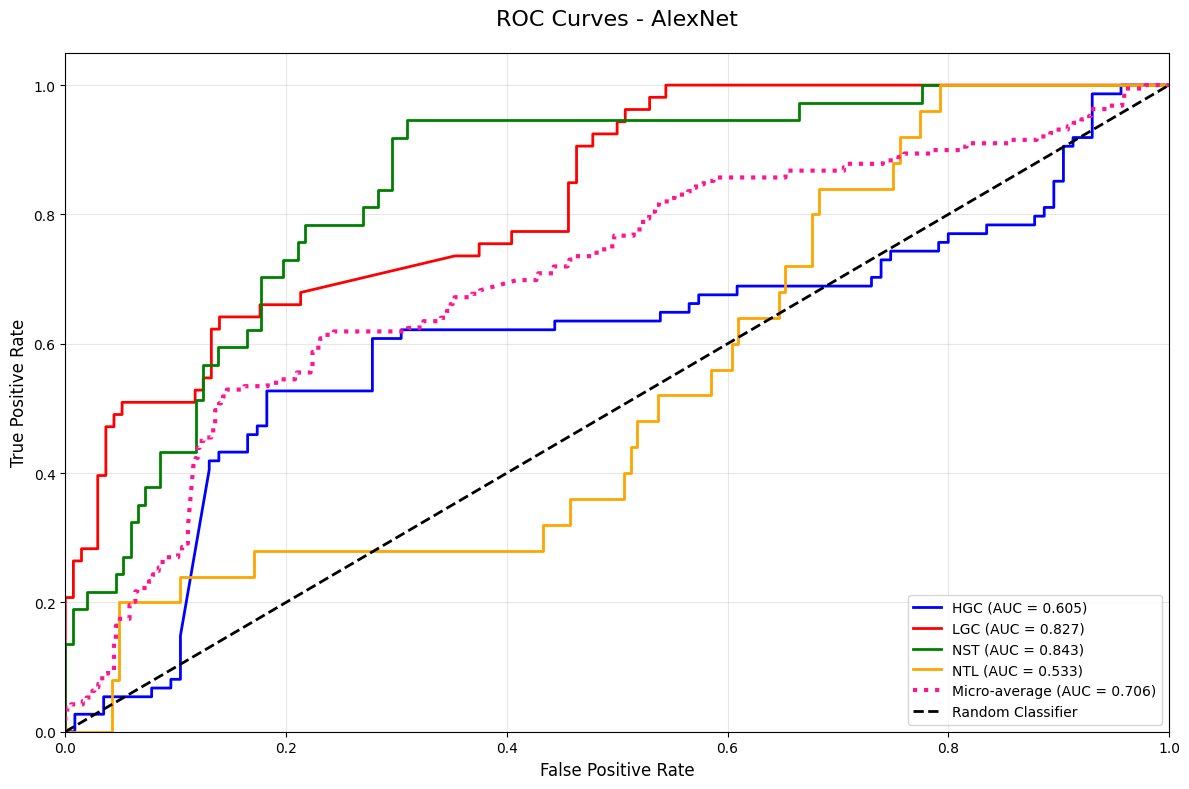


AlexNet training and evaluation complete!


In [15]:
print("=" * 80)
print("Training AlexNet with Imaging Type")
print("=" * 80)

# Create model
alexnet = create_alexnet_model(num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_alexnet = ModelTrainer(alexnet, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_alexnet = trainer_alexnet.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="AlexNet_with_ImagingType")

# Plot training history
trainer_alexnet.plot_training_history(save_path='alexnet_training_history.png')

# Evaluate model
results_alexnet = trainer_alexnet.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_alexnet['confusion_matrix'], class_names, 'AlexNet',
                      save_path='alexnet_confusion_matrix.png')

# Plot ROC curves
roc_auc_alexnet = plot_roc_curves(results_alexnet['labels'], results_alexnet['probabilities'], class_names, 'AlexNet',
                                   save_path='alexnet_roc_curves.png')

# Store results
results_alexnet['model_name'] = 'AlexNet'
results_alexnet['roc_auc'] = roc_auc_alexnet
all_results.append(results_alexnet)

print("\nAlexNet training and evaluation complete!")

# Save All Metrics to CSV

In [16]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'AlexNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: AlexNet_metrics.csv

Metrics Summary:
     Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  AlexNet         51.322751      1.497094             0.489945          0.497532      0.475172                0.547399             0.513228          0.51302       0.622951    0.513514  0.562963         74.0       0.666667     0.45283  0.539326         53.0       0.439394    0.783784  0.563107         37.0       0.230769        0.24  0.235294         25.0   0.702103   0.705579  0.605464  0.827206  0.842817  0.532927      0.605464      0.827206